# Fit MCE data taken on TmVO4 samples
both in DR (plate-like sample) and in He3 (needles)

In [1]:
# Standard Python libraries
import csv, glob, os, re, sys, time
from datetime import date
from importlib import reload
from pathlib import Path
from warnings import warn

# Data analysis libraries
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# Plotting libraries
%matplotlib
from matplotlib import pyplot as plt, rcsetup, rc, rcParams
from mplcursors import cursor
# cm stands for colormap

# Fitting libraries
from lmfit import minimize, Model, Parameters, report_fit, fit_report
from lmfit.models import LinearModel

Using matplotlib backend: Qt5Agg


In [2]:
# Create today's date variables
today = date.today()
this_month = str(today)[:-3]

## Comsol magnetic field distribution

In [3]:
# Change to directory containing MFD data
os.chdir(r'C:\Users\Pierre\Desktop\Postdoc\Software\COMSOL\TmVO4-LS5200_HC2017-07\TmVO4-LS5200_HC2017-07_COMSOL_results')

In [4]:
#%% Import magnetic field distribution from CSV file
mfdNdlFname = ['2020-11-03_TmVO4-LS5200_HC17-VII_T=p3-p4-3p1_Hext=all.csv']
for elmt in ['header', 'mfd_list', 'Hext_list', 'Tmfd_list']:
    exec(f'{elmt} = []')
mfd = {}

for fname in mfdNdlFname:
    with open(fname, newline='') as f:
        reader = csv.reader(f)
        for _ in range(9):
            row = next(reader)  # gets the first line
        for idx in range(len(row)):
            if 'mfnc' in row[idx]:
                header.append(','.join([row[idx], row[idx+1]]))
                mh = re.match('.*@ (\d+): Bext=(\d.\d+) T, T=(\d.\d) K', header[-1])
                mfd_idx = int(mh.group(1))
                Hext = float(mh.group(2))*1e4
                Tmfd = float(mh.group(3))
                mfd_key = (Hext, Tmfd)
                mfd[mfd_key] = {}
                Hext_list.append(Hext)
                Tmfd_list.append(Tmfd)
                # Read MFD data from csv file:
                # Use last string in header as column header
                # Read data from column mfd_idx+2 since, the 3 first columns are x, y, z data
                # squeeze=True in order to make it a Series instead of a DataFrame, since there is only one column for each mfd_idx
                mfd[mfd_key]['data'] = pd.read_csv(fname, comment='%', 
                                                  names=[header[-1]], 
                                                  usecols=[mfd_idx+2],
                                                  squeeze=True)
                # If all elements of an MFD are NaN, delete the corresponding entry
                if mfd[mfd_key]['data'].isna().all():
                    del mfd[mfd_key]
            # elif and else are only for debugging purposes
            elif 'T=' in row[idx]: continue
            else: header.append(row[idx])
uhext = np.unique(Hext_list)
utmfd = np.unique(Tmfd_list)
mfd[mfd_key]['data']# 

0        4227.8
1        4541.2
2        4523.0
3        4153.7
4        4227.8
          ...  
13627    4869.9
13628    4688.4
13629    3893.4
13630    4564.0
13631    4544.6
Name: mfnc.Hz (Oe) @ 56: Bext=0.5 T, T=3.1 K, Length: 13632, dtype: float64

In [5]:
# Function to find relative width of a distribution
def mfd_rel_width(mfd_data, Href):
    # purge distribution from non-zero values 
    # useful for datasets computed in a box bigger than Comsol model
    # and to ignore NaN data
    real_data = mfd_data[mfd_data>0]/Href# normalize wrt Hc or Hext

    # Find relative value of mfd that is furthest away from 1
    if abs(1-min(real_data))>abs(1-max(real_data)): 
        relative_width = abs(1-min(real_data))
    else: 
        relative_width = abs(1-max(real_data))

    return relative_width

In [6]:
# Function to create histogram from MFD data
def mfd_histogram(mfd_data, Href, nbins=75):
    # purge distribution from non-zero values 
    # useful for datasets computed in a box bigger than Comsol model
    # and to ignore NaN data
    real_data = mfd_data[mfd_data>0]/Href# normalize wrt Hc or Hext

    # Find relative value of mfd that is furthest away from 1, 
    # so as to define the histogram range base on this value
    # This allows to create a symmetric histogram, which is useful for later convolution
    half_range = mfd_rel_width(mfd_data, Href)
        
    # compute histogram of distribution
    hist_counts, edges = np.histogram(real_data, bins=nbins, 
                                      range=(1-half_range, 1+half_range),
                                      density=True)
    bin_centers = np.mean([edges[:-1], edges[1:]], 0)
    bin_widths = edges[1:]-edges[:-1]

    return hist_counts, bin_centers, bin_widths

In [7]:
#%% Compute probability distribution of fields at a given value of T and Hext
for key in mfd.keys():
    Hext = key[0]
#     Tmfd = key[1]
    # Compute mfd histogram and unpack it into into dictionary key
    mfd[key]['rel_width'] = mfd_rel_width(mfd[key]['data'], Hext)
    mfd[key]['hc'], mfd[key]['binCenters'], mfd[key]['binWidths'] = \
    mfd_histogram(mfd[key]['data'], Hext, nbins=75)

In [8]:
#%% Plot distribution of fields at a given value of T and Hext
fig, ax = plt.subplots()

plt_keys = {'fixed T': [(uhext[i], utmfd[2])  for i in [0, 2, 4, 6]],
           'fixed H': [(uhext[-1], utmfd[i]) for i in [0, 2, 3, 5]]}
# param_index = 1# 0 is constant T, 1 is constant Hext, see param_range
# param_range = [, [i+4*8 for i in [1,3,5,7]]]# first range corresponds to a 
# # field dependence at constant temp, second range corresponds to a 
# # temperature dependence at constant field
# # rng = param_range[param_index]#
Hc = 5e3
Tc = 2.2 
setting = 'fixed H'

if setting=='fixed T':
    fixedp = Tmfd = plt_keys[setting][0][1]
    varp_idx = 0
    pc = Hc
    lgd_title = '$H_{\mathrm{ext}}/H_c$'
    ann_str = f'$T/T_c=$ {Tmfd/Tc:.2g}'
elif setting=='fixed H':
    fixedp = Hext = plt_keys[setting][0][0]
    varp_idx = 1
    pc = Tc
    lgd_title = '$T/T_c$'
    ann_str = ''.join('$H_{\mathrm{ext}} =$' f' {Hext/1e3:.3g} kOe')

for key in plt_keys[setting]:
#     if param_index==0: lgd_str = f'{Hext/Hc:.2g}'
#     elif param_index==1: lgd_str = f'{Tndl/Tc:.2g}'
    lgd_str = f'{key[varp_idx]/pc:.2g}'
    p = plt.plot(mfd[key]['binCenters'], mfd[key]['hc'], '.-', label=lgd_str)
# plt.xlim([.6966,1.05])

lgd = plt.legend(title=lgd_title) 
anndist = plt.annotate(ann_str, xy=(.35, .85), xycoords='axes fraction', 
                       bbox=dict(boxstyle='round', fc='w'))# add annotation
# needle_title = 'Field distribution in TmVO$_4$ needles'
# param_title = [f', $T=$ {Tndl:%.2g} K', f', $H_{\mathrm{ext}}=$ {Hext:%.2d} Oe']
# title(''.join([needle_title, param_title[param_index]])
plt.xlabel('$H_{\mathrm{in}}/H_{\mathrm{ext}}$')
plt.ylabel('Probability density')
# plt.xticks = np.arange(.7, 1, .1)
plt.grid(b=True)
cursor()

In [9]:
#%% Compute the average value of ratio of internal to external magnetic field 
for key in mfd.keys():
    mfd[key]['Hinm_Oe'] = np.round(
        np.sum(
        mfd[key]['binCenters']*mfd[key]['hc']*mfd[key]['binWidths']
        )*key[0]
        )

In [10]:
#%% Check results for given range of temperatures/field

# Check that the ratio of Hinm/Hext is roughly constant inside the
# ordered phase, thus allowing to use the value at 0.3 K and 1000 Oe as a proxy
for elmt in ['h', 'Hinm', 'Hext', 'Tmfd']:
    exec(f'{elmt}=[]')# initialize lists
    
for key in plt_keys[setting]:
    Tmfd.append(key[1])
    Hext.append(key[0])
    Hinm.append(mfd[key]['Hinm_Oe'])
    h.append(mfd[key]['Hinm_Oe']/key[0])

# rescaling factor, due to demag; take value at H~Hc and T~Tc/2, which is where the MCE data is interesting
rescaling = mfd[list(mfd)[-6]]['Hinm_Oe']/list(mfd)[-6][0]
rescaling

0.9808

## MCE data analysis

In [11]:
datFilePath = r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE'
os.chdir(datFilePath)

In [12]:
# Initialize dictionaries that will contain data for each run
for key in ['dataset', 'run_date', 'I', 'R', 'H', 'T', 'Tpuck', \
            'Hi', 'Ti', 'Tpucki', 'dHi','dH', 'dT', 'd1T', 'd2T',\
            'mce_sim', 'mce_fit', 'refsweep', 'usr', 'utbath', 'sweeprates']:
    if key not in locals():
        exec(f'{key}={{}}')

In [13]:
runIDs = []
for runID in range(2,8):
    file_str = glob.glob(f'Run{runID}_*.dat')[0]
    m = re.match('Run(\d)_(0p\d).*', file_str)
    runIDs.append(runID)# int(m.group(1)) also works
    dataset[runID] = pd.read_csv(file_str, sep=', ', engine='python')
    I[runID] = float(m.group(2).replace('p','.'))*1e-6# input current, in amps

print(dataset[runID])

             Time  Temperature(K)      Field(T)  LockinX(V)  LockinY(V)  \
0      3584632596          0.3999  2.041789e-07    0.001983   -0.000061   
1      3584632597          0.3999  2.041789e-07    0.001983   -0.000061   
2      3584632598          0.4000  2.041789e-07    0.001982   -0.000061   
3      3584632599          0.3997  2.041789e-07    0.001982   -0.000061   
4      3584632600          0.3999  2.041789e-07    0.001983   -0.000061   
...           ...             ...           ...         ...         ...   
12074  3584644672          0.6001 -1.265910e-06    0.001244   -0.000021   
12075  3584644673          0.5999 -1.265910e-06    0.001244   -0.000021   
12076  3584644674          0.6001 -1.265910e-06    0.001244   -0.000021   
12077  3584644675          0.6000 -1.265910e-06    0.001244   -0.000021   
12078  3584644676          0.6002 -1.265910e-06    0.001244   -0.000021   

       Date = 8/3/2017 12:16 PM  
0                           NaN  
1                           NaN

In [14]:
dataset[2].columns

Index(['Time', 'Temperature(K)', 'Field(T)', 'LockinX(V)', 'LockinY(V)',
       'Date = 7/29/2017 9:53 PM'],
      dtype='object')

### Reproducing betamodel.mat
Which is the surface fit used in Matlab to convert the platform resistance data of the lockin to inverse temperature data:
$$ 1/T = \mathrm{betamodel}(V_X) $$

In [15]:
# The content of this cell was copy-pasted from the content of the 
# BetaModel sfit variable, as shown in Matlab after importing betamodel.mat

# Coefficients (with 95% confidence bounds):
p00 =     -0.2734#  (-0.2752, -0.2716)
p10 =    9.78e-06#  (8.802e-06, 1.076e-05)
p01 =      0.0011#  (0.001096, 0.001104)
p20 =   -4.45e-09#  (-5.037e-09, -3.862e-09)
p11 =  -1.322e-08#  (-1.427e-08, -1.216e-08)
p02 =  -2.275e-07#  (-2.305e-07, -2.246e-07)
p30 =   9.561e-13#  (7.765e-13, 1.136e-12)
p21 =   3.565e-12#  (3.342e-12, 3.789e-12)
p12 =   4.659e-12#  (4.225e-12, 5.092e-12)
p03 =    3.37e-11#  (3.272e-11, 3.468e-11)
p40 =  -8.502e-17#  (-1.093e-16, -6.072e-17)
p31 =  -6.191e-16#  (-6.464e-16, -5.918e-16)
p22 =   8.508e-17#  (4.041e-17, 1.298e-16)
p13 =  -6.088e-16#  (-6.86e-16, -5.316e-16)
p04 =  -2.724e-15#  (-2.872e-15, -2.577e-15)
p50 =   2.293e-21#  (1.105e-21, 3.48e-21)
p41 =   3.892e-20#  (3.749e-20, 4.034e-20)
p32 =   -1.77e-20#  (-1.973e-20, -1.567e-20)
p23 =   1.698e-21#  (-1.673e-21, 5.069e-21)
p14 =   2.632e-20#  (2.116e-20, 3.148e-20)
p05 =   8.741e-20#  (7.917e-20, 9.565e-20)

# Linear model Poly55:
def betamodel(x,y):
    """
    x: array
        Magnetic field data.
    y: array
        Platform resistance data.
    """
    val = p00 + p10*x + p01*y + p20*x**2 + p11*x*y + p02*y**2 + p30*x**3 +\
    p21*x**2*y + p12*x*y**2 + p03*y**3 + p40*x**4 + p31*x**3*y \
    + p22*x**2*y**2 + p13*x*y**3 + p04*y**4 + p50*x**5 + p41*x**4*y \
    + p32*x**3*y**2 + p23*x**2*y**3 + p14*x*y**4 + p05*y**5
    return val

### Compute platform resistance
obtained from the voltage data $V_X$ of the X channel of the lock-in amplifier and the input electrical current $I$ as:
$$ R_\mathrm{platform} = V_X / I $$

In [16]:
for runID in runIDs:
    Hi[runID] = {'raw':dataset[runID]['Field(T)']*1e4} # Magnetic field, in Oersted
    Tpucki[runID] = {'raw':dataset[runID]['Temperature(K)']}# Puck (bath) temperature, in Kelvin
    R[runID] = dataset[runID]['LockinX(V)']/I[runID]# Platform resistance, in Volts
    Ti[runID] = {'raw':1/betamodel(Hi[runID]['raw'], R[runID])}
    run_date[runID] = re.match('.* (\d+/\d+/20\d{2}) .*', dataset[runID].columns[5]).group(1)

In [17]:
xlabel_mce = '$H$ (Oe)'
ylabel_mce = '$T + \Delta T_\mathrm{MCE}$ (K)'
# title_mce = f'MCE traces run {runID} - {run_date[runID]}'

In [18]:
# Raw MCE traces
# runID = 6
%matplotlib 
pltIDs = [2]
for runID in pltIDs:#runIDs[:]:
    plt.figure(num=runID)
    plt.plot(Hi[runID]['raw'], Ti[runID]['raw'])
    plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Raw MCE traces run #{runID} - {run_date[runID]}')

Using matplotlib backend: Qt5Agg


In [19]:
for runID in runIDs:
    for el in [Hi, Ti]:
        el[runID]['smoothed'] = gaussian_filter1d(el[runID]['raw'], 1)
        el[runID]['sssmooth'] = gaussian_filter1d(el[runID]['raw'], 5)

In [20]:
# Smoothed MCE traces
pltIDs = [2]
for runID in pltIDs:#runIDs:
    plt.figure(num=runID+10)
    labels = ['raw', 'smoothed', 'sssmooth']
    for lbl in labels:
        plt.plot(Hi[runID][lbl], Ti[runID][lbl], label=lbl)
    plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Smoothed MCE traces run #{runID} - {run_date[runID]}')
    plt.legend()

In [40]:
# Compute dH data and extract sweeprates from it
for runID in runIDs:
    dHi[runID] = np.diff(Hi[runID]['smoothed'])
#     dT[runID] = pd.Series(np.diff(Ti[runID]['smoothed']))
#     d1T[runID] = dT[runID][dH[runID]>0]/dH[runID][dH[runID]>0]
    udh, cdh = np.unique(np.round(dHi[runID]), return_counts=True)
    sweeprates[runID] = udh[np.logical_and(cdh>250, udh!=0)]# 250 seems to be the best value to eliminate datapoints that are not actual traces
    usr[runID], csr = np.unique(abs(sweeprates[runID]), return_counts=True)

dHi[runID]#[d1T[runID].idxmax()]

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
class DataError(Exception):
    """Customized errors for the purpose of MCE data analysis."""
    def __init__(self, message):
        self.message = message

In [23]:
# Function to separate traces based on sweeprate
def sep_sweeprates(sweeprates, dH, X):
    Xout = {}
    
    if len(sweeprates)<1:
        raise DataError("No value of sweeprate was stored for this run.")
    elif len(sweeprates)==1:
        sr = sweeprates[0]
        Xout[sr] = pd.Series(X)
    else:
        for ir, sr in enumerate(sweeprates):
            if ir==0:
                refsweep = np.mean([sr, sweeprates[ir+1]])
                out = X[dH<refsweep]
            elif ir<len(sweeprates)-1:
                rsm = np.mean([sr, sweeprates[ir-1]])
                rsp = np.mean([sr, sweeprates[ir+1]])
                out = X[np.logical_and(dH<rsp, dH>rsm)]
            else:
                refsweep = np.mean([sr, sweeprates[ir-1]])
                out = X[dH>refsweep]
            Xout[sr] = pd.Series(out)

    return Xout

In [24]:
# Compute H, T, Tpuck
for runID in runIDs:
    for pq in [(Hi, H), (Ti, T), (Tpucki, Tpuck)]:# pq stands for physical quantity
#         # Initialize dictionaries to store data
#         if runID not in pq[0].keys():
#             pq[0][runID] = {}
#         if 'dict' not in pq[0][runID].keys():
        pq[0][runID]['dict'] = {}# create/reset dictionary
        pq[1][runID] = pd.DataFrame()# create/reset dataFrame
            
        # Reduce length of reference arrays by 1, since dH has 1 element less than these
        try:
            Xm = np.mean([pq[0][runID]['smoothed'][:-1], pq[0][runID]['smoothed'][1:]], 0)
        except KeyError:
            Xm = np.mean([pq[0][runID]['raw'][:-1], pq[0][runID]['raw'][1:]], 0)
        
        pq[0][runID]['dict'] = sep_sweeprates(sweeprates[runID], dHi[runID], Xm)

        # Concatenate separated data into a single DataFrame, for each run
        try:
            pq[1][runID] = pd.concat(pq[0][runID]['dict'], axis=1)# 0 was chosen as key for simplicity
        except ValueError:
            warn(f"Concatenation failed for data of run #{runID}.")
            break

In [25]:
# Compute dH, dT
for runID in runIDs:
    for el in [Hi, Ti]:
        el[runID]['sssmooth'] = gaussian_filter1d(el[runID]['raw'], 50/max(abs(sweeprates[runID])))

    dTm = np.diff(Ti[runID]['sssmooth'])
    dHm = np.diff(Hi[runID]['sssmooth'])#dHi[runID]
    dTd = sep_sweeprates(sweeprates[runID], dHi[runID], dTm)
    dHd = sep_sweeprates(sweeprates[runID], dHi[runID], dHm)

    for pq in [(dHd, dH), (dTd, dT)]:# pq stands for physical quantity
        pq[1][runID] = pd.DataFrame()# create/reset dataFrame
        # Concatenate separated data into a single DataFrame, for each run
        try:
            pq[1][runID] = pd.concat(pq[0], axis=1)# 0 was chosen as key for simplicity
        except ValueError:
            warn(f"Concatenation failed for data of run #{runID}.")
            break
            
    dHfilter = abs(dH[runID])>0
    d1T[runID] = dT[runID][dHfilter]/dH[runID][dHfilter]


In [26]:
# Unused as of 2021-01-05; delete if not used after that
# dHm = np.mean([dH[runID][:-1], dH[runID][1:]], 0)
# d2Tm = np.diff(dT[runID])
# dHfilter = abs(dHm)>0


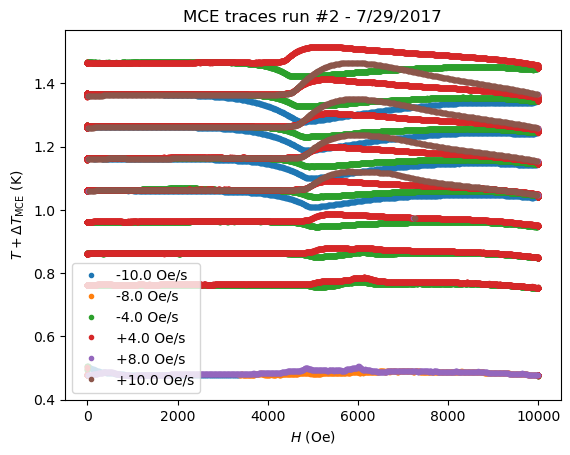

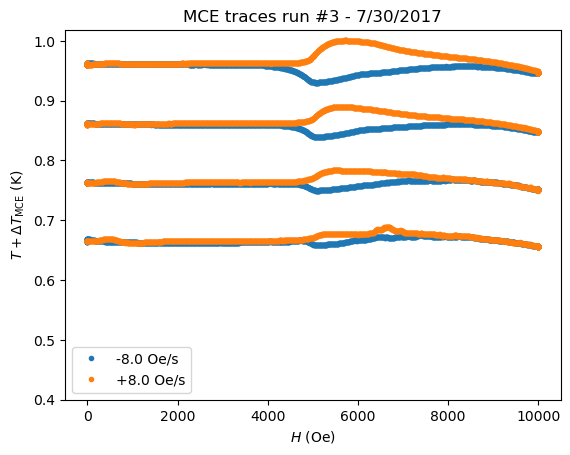

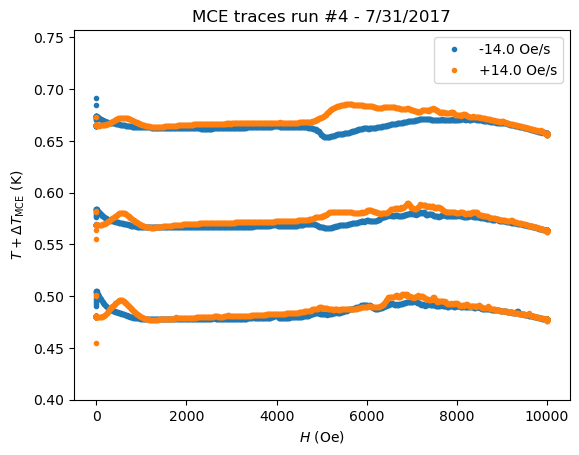

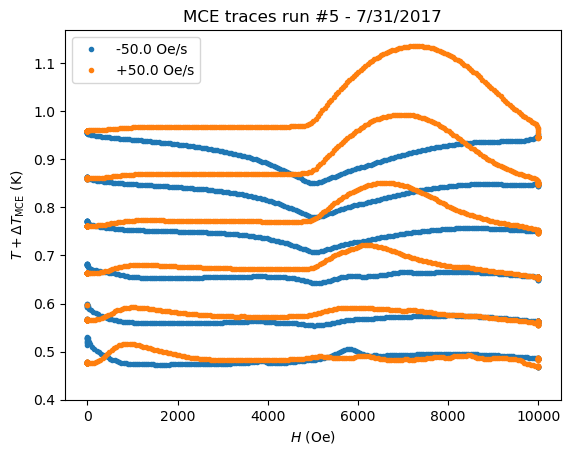

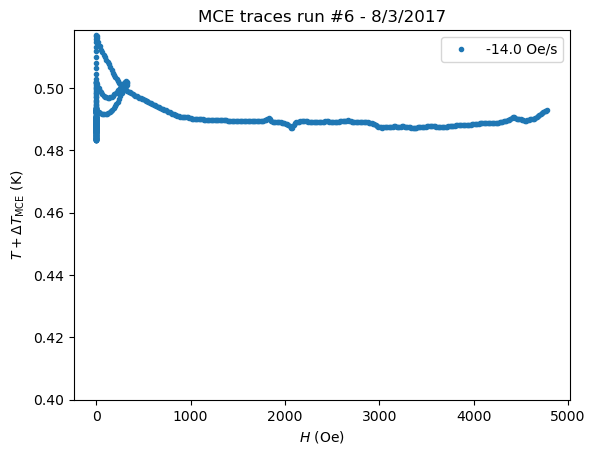

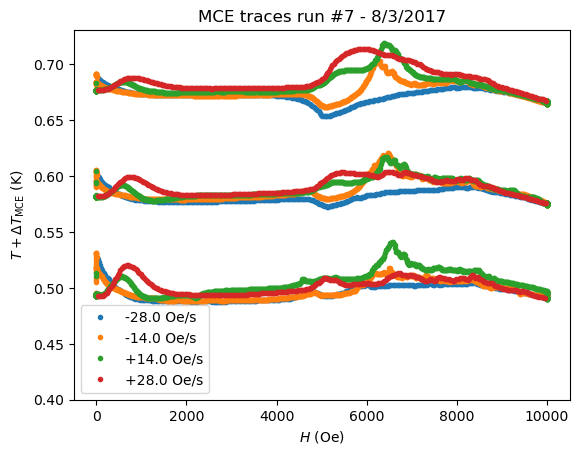

In [27]:
# import ipywidgets as widgets
%matplotlib inline
for runID in runIDs:
    fig = plt.figure()
    for i, sr in enumerate(H[runID].columns):
        plt.plot(H[runID][sr], T[runID][sr], '.', label=f'{sr:+.1f} Oe/s')
    plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'MCE traces run #{runID} - {run_date[runID]}')
    plt.legend()

In [28]:
sys.path.append(r'C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts')
import MCE_simulations.mce_no_demag as mce
# mce = reload(mce)# if mce is changed

In [29]:
# Identify values of bath temperature used for the measurements
npoints = 250
for runID in runIDs:
    # ut, ct = np.unique(np.round(Tpucki[runID]['raw'], 2), return_counts=True)# Use raw data
    ut, ct = np.unique(np.round(Tpuck[runID], 1), return_counts=True)# Same, by construction of Tpuck[runID]

    # Show counts for each value of bath temperature, ignoring NaN
    print(runID, [[ut[ct>npoints][i], ct[ct>npoints][i]] for i in range(len(ut[ct>npoints]))])
    utbath[runID] = ut[ct>npoints]# select only those values that occur in more than 500 data points
utbath[runID]#

2 [[0.4, 2393], [0.7, 5087], [0.8, 5086], [0.9, 5079], [1.0, 7177], [1.1, 7178], [1.2, 7175], [1.3, 7177], [1.4, 5086]]
3 [[0.6, 2588], [0.7, 2589], [0.8, 2589], [0.9, 2588]]
4 [[0.4, 1518], [0.5, 1523], [0.6, 1523]]
5 [[0.4, 476], [0.5, 499], [0.6, 492], [0.7, 494], [0.8, 490], [0.9, 491]]
6 [[0.4, 752]]
7 [[0.4, 2315], [0.5, 2327], [0.6, 2324]]


array([0.4, 0.5, 0.6])

In [30]:
# Test bath_temp function
sr = sweeprates[runID][0]
for Tb in utbath[runID][:1]:
    dataFilter = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<4e3),
                                np.round(Tpuck[runID][sr], 1)==Tb)
    # print(min(dTp), max(dTp))
    Hp = H[runID][sr][dataFilter]
    Tp = T[runID][sr][dataFilter]
    Tb = mce.bath_temp([Tp], rel_temp_bound=1e-3, timeit=True)
    print(Tb)

Runtime of bath_temp function: 0.0007 seconds
0.4879577977347799


### For given field and temperature, find two closest mfd's

In [31]:
def closest_mfd_values(ptest, upmfd):
    # sort array of fields by distance to current value of field and keep the two closest values
    dpmfd = abs(upmfd-ptest)# 
    closest2p = upmfd[np.argsort(dpmfd)][:2]
    pweights = 1 - dpmfd[np.argsort(dpmfd)][:2]/abs(np.diff(closest2p)[0])

    # if the value of field is below the lowest value in the array or above the highest, 
    # i.e. if the distance between the former and the second closest value in the array is larger than 
    # the distance between the two closest values in the array
    if dpmfd[np.argsort(dpmfd)][1]>=abs(np.diff(closest2p)[0]):
        # only keep the single closest value in the array (i.e. the lowest or the highest)
        closest2p = closest2p[:1]
        pweights = np.ones(1)
        # for instance: if H = 345 and the array is [1000, 2000, 3000], only keep 1000,
        # since abs(2000-345)>abs(2000-1000)
    
    return closest2p, pweights

### Compute second derivative of data

In [32]:
%matplotlib
pltIDs = [2]
sr = -10
runID = 2
d2Ttest = {}
d2Ttest[sr] = pd.Series(gaussian_filter1d(d1T[runID][sr], 10))
for runID in pltIDs:#runIDs:
    plt.figure()
    plt.plot(H[runID][sr], d1T[runID][sr])
    plt.plot(H[runID][sr], d2Ttest[sr].diff()/dH[runID][sr]*1e2)
#     plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Smoothed MCE traces run #{runID} - {run_date[runID]}')
    plt.ylim(np.arange(-1, 2, 2)*1e-4)
#     plt.legend()

Using matplotlib backend: Qt5Agg


In [35]:
for elmt in ['d2T', 'd2Tdf', 'HTcd1', 'HTcd2', 'dHc']:
    exec(f'{elmt} = {{}}')

In [36]:
for runID in runIDs[:]:
    for elmt in ['d2T', 'd2Tdf', 'HTcd1', 'HTcd2', 'dHc']:
        exec(f'{elmt}[runID] = {{}}')
    for sr in sweeprates[runID][:]:
        for elmt in ['d2Tdf', 'HTcd1', 'HTcd2', 'dHc']:
            exec(f'{elmt}[runID][sr] = {{}}')
#         Tf = []
#         idx = 0 
#         while len(Tf)<npoints*10/abs(sr):
#             Tb = utbath[runID][idx]
#             dataFilter = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<9.99e3),
#                                         np.round(Tpuck[runID][sr], 1)==Tb)
#             Hf = H[runID][sr][dataFilter]
#             Tf = T[runID][sr][dataFilter]
#             idx = idx+1
#             if idx>len(utbath[runID])-1:
#                 warn(f"No temperature value found for run #{runID}")
#             continue

#         # Find MFD with temperature closest to Tbath
#         Tbmfd, _ = closest_mfd_values(np.mean(Tf[Hf<4.5e3]), utmfd)
#         mfd_key = (5e3, Tbmfd[0])
#         # Compute the number of datapoints in the range of the corresponding mfd
#         hnpoints = abs(abs(Hf/Hc-1).idxmin() - abs(Hf/Hc-(1-mfd[mfd_key]['rel_width'])).idxmin())
#     #     # Compute the corresponding histogram
#     #     mfd[mfd_key]['hc'], _, _ = mfd_histogram(mfd[mfd_key]['data'], 
#     #                                              mfd_key[0], nbins=hnpoints)

        d1Tgauss = pd.Series(gaussian_filter1d(d1T[runID][sr], 50/abs(sr)))
        d2T[runID][sr] = d1Tgauss.diff()/dH[runID][sr]
        for Tb in utbath[runID][:]:
            dataFilter = np.logical_and(np.logical_and(H[runID][sr]>4e3, H[runID][sr]<5.5e3),
                                        np.round(Tpuck[runID][sr], 1)==Tb)
            Hf = H[runID][sr][dataFilter]
            Tf = T[runID][sr][dataFilter]
            d1Tf = d1T[runID][sr][dataFilter]
            d2Tf = d2T[runID][sr][dataFilter]
            try:
                HTcd1[runID][sr][Tb] = (Hf[abs(d1Tf).idxmax()], Tf[abs(d1Tf).idxmax()])
                HTcd2[runID][sr][Tb] = (Hf[d2Tf.idxmax()], Tf[d2Tf.idxmax()])
                dHc[runID][sr][Tb] = 0.5*abs(Hf[abs(d1Tf).idxmax()]-Hf[d2Tf.idxmax()])
            except ValueError:
                continue          

#         print(HTcd1[runID][sr], HTcd2[runID][sr])
    d2Tdf[runID] = pd.DataFrame(d2T[runID])

In [194]:
pltIDs = [2]
# sr = -4
for runID in pltIDs:#runIDs:
    dirname = [s for s in next(os.walk('.'))[1] if f'Run{runID}' in s][0]
    plt.figure()
    susr = usr[runID][2:]
    for sr in sweeprates[runID][abs(sweeprates[runID])==susr]:#[-susr, susr]:#
#     plt.plot(H[runID][sr], d1T[runID][sr])
#     plt.plot(H[runID][sr], d2T[runID][sr]*1e2)
#     plt.ylim(np.arange(-1, 2, 2)*1e-4)
        plt.plot(H[runID][sr], T[runID][sr], '.', label=f'{sr:+.1f} Oe/s')
        pltHTcd1 = np.asarray(list(HTcd1[runID][sr].values()))
        pltHTcd2 = np.asarray(list(HTcd2[runID][sr].values()))
        plt.plot(pltHTcd1[:,0], pltHTcd1[:,1], '*', ms=9, label='max 1st der.')
        plt.plot(pltHTcd2[:,0], pltHTcd2[:,1], '*', ms=9, label='max 2nd der.')
#         plt.ylim(bottom=1, top=1.5)
        plt.xlabel(xlabel_mce)
        plt.ylabel(ylabel_mce)
        plt.title(f'Smoothed MCE traces run #{runID} - {run_date[runID]}')
        plt.legend(loc='upper left')
        
    # Save figure
    savedir = f'{dirname}//{this_month}_MCE_fitting//'
    Path(savedir).mkdir(parents=True, exist_ok=True)
    saveHcname = f'{savedir}{str(today)}_run{runID}_sweeprate+-{int(susr)}Oeps_Hc'

In [73]:
header = 'Hc[max(dH/dT)] (Oe), T[Hc[max(dH/dT)]] (K), \
Hc[max(d^2H/dT^2)] (Oe), T[Hc[max(d^2H/dT^2)]] (K)'
data = np.vstack([pltHTcd1[:,0]*rescaling, pltHTcd1[:,1],
                  pltHTcd2[:,0]*rescaling, pltHTcd2[:,1]]).T
plt.savefig(f'{saveHcname}.png', dpi=300)
np.savetxt(f'{saveHcname}.csv', data, fmt='%.3e', delimiter=',', header=header)

To do as of 2021-01-06:
* Save Hc values in pandas dataframe, with temperature and sweeprates as additional columns
    - fit Hc at each temperature vs sweeprate --> scaling with sweeprate?
* For the case of the 'needle-shaped samples, simulated curves have their upturns coincide with those of the data when determining Hc from second derivatives of MCE data, both for up- and downsweep; confirm with data on sample measured in DR

### Simulate MCE curves

In [150]:
# Callback function for debugging
def iter_callback(params, iter_num, resid, H, data=None, trace=None):
    print(iter_num, params['ODE_prefactor'].value)
    
class FakeLMFitResult:
    """
    Dummy class that has an attribute 'params', similar to the result of a fit with lmfit.
    """
    def __init__(self, params):
        self.params = params

#### Function to compute variables required to simulate MCE curves

In [211]:
def xfit_mce(H, T, Tpuck, Tb, htcd1, htcd2, fitRange, mfd, srpm, us, utmfd, fit=False):
    d = {}
    Hc = {}
    for elmt in ['Hc', 'Hf', 'Tf', 'Hffit', 'Tffit', 'Tbath', 'prms', 'trace_str']:
        exec(f'{elmt} = []', d)
    for idx, sr in enumerate(srpm):#
        # select data to analyze; note: solve_ivp fails for H<1 Oe (H/Hc0<2e-3)
        dataFilter = np.logical_and(np.logical_and(H[sr]>10, H[sr]<9.99e3),
                                    np.round(Tpuck[sr], 1)==Tb)
        if len(T[sr][dataFilter])<100: continue
        d['Hf'].append(H[sr][dataFilter])
        d['Tf'].append(T[sr][dataFilter])
        d['Tbath'].append(mce.bath_temp([d['Tf'][-1][d['Hf'][-1]<4e3]]))
        if d['Tbath'] is None: continue
        Hf_filter = np.logical_and(d['Hf'][-1]>fitRange[0], d['Hf'][-1]<fitRange[1])
        d['Hffit'].append(d['Hf'][-1][Hf_filter])
        d['Tffit'].append(d['Tf'][-1][Hf_filter])
        if len(d['Hffit'][-1])<50: continue
        if sr>0: 
            d['trace_str'].append('upsweep')
            Hc[sr] = htcd2[sr][Tb][0]
        else: 
            d['trace_str'].append('downsweep')
            Hc[sr] = htcd2[sr][Tb][0]

        
    if len(d['Hf'])==0: return None
    Tbm = np.mean(d['Tbath'])
    # Find MFD with temperature closest to Tbath
    Tbmfd, _ = closest_mfd_values(Tbm, utmfd)
    Hc0 = 5e3
    mfd_key = (Hc0, Tbmfd[0])
    # Compute the number of datapoints in the range of the corresponding mfd
    hnpoints = abs(abs(d['Hf'][0]/Hc0-1).idxmin() - abs(d['Hf'][0]/Hc0-(1-mfd[mfd_key]['rel_width'])).idxmin())
    # Compute the corresponding histogram
    mfd[mfd_key]['hc'], _, _ = mfd_histogram(mfd[mfd_key]['data'], 
                                             mfd_key[0], nbins=hnpoints)

    for idx, sr in enumerate(srpm):#
        # Define fit parameters
        d['prms'].append(mce.mce_parameters(Hc=Hc[sr], sweeprate=us, 
                                            kappa=.05*np.sqrt(Tbm), 
                                            Tc0=2.2, Tbath=Tbm))
    if fit is True:
        out = minimize(mce.xmce_residual, d['prms'][-1], method='least_squares',
                       args=(d['Hffit'], d['Tffit'], d['trace_str']),
                       kws={'mfd_hc':mfd[mfd_key]['hc'], 'Tbath':d['Tbath']}, 
                       iter_cb=None)#, **{'ftol':1e-15})#, max_nfev=100)#)
    else:
        out = None
    
    return d['Hf'], d['Tf'], d['trace_str'], mfd_key, out, d['prms']

In [212]:
# import ipywidgets as widgets
# %matplotlib 
runID = 2
for dico in [mce_fit, mce_sim]:
    if runID not in dico.keys():
        dico[runID] = {}

dirname = [s for s in next(os.walk('.'))[1] if f'Run{runID}' in s][0]
fitRange = {2:[4e3, 9e3], 3:[4e3, 6e3], 4:[4e3, 6e3], 5:[4e3, 8e3], 7:[4e3, 6.3e3]}
# prm_rng = {2:(range(0,3,2), range(1,len(utbath[2]))), 3:None}

for us in usr[runID][-1:]:
    lgd_labels = []
    plt.figure(num=int(us))
    srpm = sweeprates[runID][abs(sweeprates[runID])==us]
    for Tb in utbath[runID][1:]:
        result = xfit_mce(H[runID], T[runID], Tpuck[runID], Tb, HTcd1[runID], HTcd2[runID],
                          fitRange[runID], mfd, srpm, us, utmfd, fit=False)
        if result is None: continue
        Hf, Tf, strace, mfd_key, out, prms = result
#         if out is not None:
#             mce_fit[runID][us] = out

        for idx, sr in enumerate(srpm):#
            if out is None:
                out = FakeLMFitResult(prms[idx])
                print(f'{sr:+.0f} Oe/s\t Tb = {Tb} K\t Hc = {out.params["Hc"].value:.0f} Oe\
                ODE prefactor = {out.params["ODE_prefactor"].value:.3f}')
                
            mce_sim[runID][sr] = mce.mce_residual(out.params, Hf[idx], data=None, 
                                                  trace=strace[idx], mfd_hc=mfd[mfd_key]['hc'])
            srlabel = f'{sr:+.0f} Oe/s'
            out = None

            # Plot results
            plt.plot(Hf[idx], Tf[idx], '.', color=f'C{idx}', markersize=2,
                     label=f'data {srlabel}' if srlabel not in lgd_labels else '_nolegend_')
        #     plt.plot(Hf, mce_sim[sr], '-', color=f'C{idx}', label=f'fit {sr:+.1f} Oe/s')
            # Plotting the fit with sorted arguments avoids lines connecting low and high Hf values
            cutoff = 20
            plt.plot(Hf[idx][:-cutoff].sort_values(), mce_sim[runID][sr][Hf[idx][:-cutoff].argsort()], 
                     '-', linewidth=1, color=f'C{idx}',
                     label=f'fit {srlabel}' if srlabel not in lgd_labels else '_nolegend_')
            # Keep track of legend labels to avoid duplicates
            if srlabel not in lgd_labels:
                lgd_labels.append(srlabel)
    plt.title(f'MCE traces run #{runID} - {run_date[runID]}\n\
    Up- and downsweep fits constrained together and include MFD')
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.legend(loc='upper left')
    
    # Save figure
    savefitname = f'{dirname}//{this_month}_MCE_fitting//\
{str(today)}_run{runID}_sweeprate+-{int(us)}Oeps_+fits_noMFD.png'
#     plt.savefig(savefitname, dpi=300)
cursor()

-10 Oe/s	 Tb = 1.0 K	 Hc = 4930 Oe                ODE prefactor = 3.099
+10 Oe/s	 Tb = 1.0 K	 Hc = 4867 Oe                ODE prefactor = 3.099
-10 Oe/s	 Tb = 1.1 K	 Hc = 4870 Oe                ODE prefactor = 3.242
+10 Oe/s	 Tb = 1.1 K	 Hc = 4784 Oe                ODE prefactor = 3.242
-10 Oe/s	 Tb = 1.2 K	 Hc = 4784 Oe                ODE prefactor = 3.379
+10 Oe/s	 Tb = 1.2 K	 Hc = 4682 Oe                ODE prefactor = 3.379
-10 Oe/s	 Tb = 1.3 K	 Hc = 4690 Oe                ODE prefactor = 3.512
+10 Oe/s	 Tb = 1.3 K	 Hc = 4550 Oe                ODE prefactor = 3.512


In [ ]:
savefitname
plt.savefig(savefitname, dpi=300)

## Include Comsol MFD in MCE fits

### Test computation of MCE curve convolved with MFD

In [ ]:
runID = 2
sr = 10
Tb = 1.0
dataSel = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<9.99e3),
                         np.round(Tpuck[runID][sr], 1)==Tb)
Hf = H[runID][sr][dataSel]
Tf = T[runID][sr][dataSel]

In [ ]:
Ttest = Tb
closest2T, Tweights = closest_mfd_values(Ttest, utmfd)
print(Ttest, closest2T, Tweights)
Htest = Hf[200]
closest2H, Hweights = closest_mfd_values(Htest, uhext)
print(Htest, closest2H, Hweights)

In [ ]:
# Update mfd_key with the closest temperature
mfd_key = (5e3, closest2T[0])

# Compute the number of datapoints in the range of the corresponding mfd
hnpoints = abs(Hf/Hc-1).idxmin() - abs(Hf/Hc-(1-mfd[mfd_key]['rel_width'])).idxmin()

# Compute the corresponding histogram
mfd[mfd_key]['hc'], mfd[mfd_key]['binCenters'], mfd[mfd_key]['binWidths'] = \
mfd_histogram(mfd[mfd_key]['data'], Hext, nbins=hnpoints)

In [ ]:
prms = mce.mce_parameters(Hc0=Hc0, sweeprate=-sr, Tc0=Tc0, Tbath=Tb)
Tcalc = mce.mce_residual(prms, Hf, trace='downsweep')
Tcalc[int(len(Tcalc)/2)-50:int(len(Tcalc)/2)+50]

In [ ]:
from scipy.signal import convolve
# Update mfd_key to use the mfd closest to the critical field (H ~ 5 kOe)
Tout = convolve(Tcalc, mfd[mfd_key]['hc'], mode='same')/sum(mfd[mfd_key]['hc'])
# Check that the convolution acts on a wide enough range of magnetic fields. 
# Might require some kind of adaptability of its width...
# At the very least, make sure the width is correct around the critical field
Tout[int(len(Tout)/2)-50:int(len(Tout)/2)+50]

In [ ]:
# Plot convolution of magnetic field with MFD
# fig, ax = plt.subplots()
plt.plot(Hf, Tcalc)
plt.plot(Hf, Tout)
cursor()